
# 2D ERT modeling and inversion


In [107]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

## Geometry definition
Create geometry definition for the modelling domain. ``worldMarker=True``
indicates the default boundary conditions for the ERT



(<Axes: >, None)

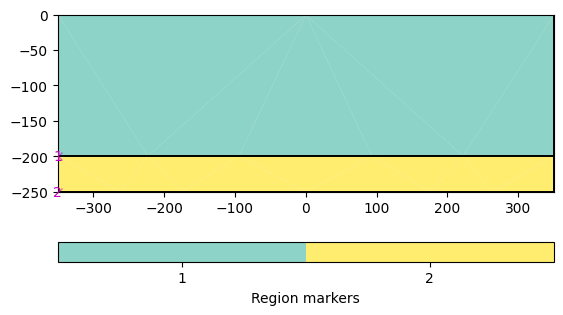

In [108]:
world = mt.createWorld(start=[-350, 0], end=[350, -250], layers=[-200],
                       worldMarker=True)
pg.show(world)

Calculate fault points position


In [109]:
x1 = -125
y1 = -200
y2 = -250
x2 = x1 - np.tan(np.radians(-30)) * (y2 - y1) #Dip 60°

Create fault and division between Floresta and Cretacic

In [110]:
fault = mt.createPolygon([[x1, y1], [x2, y2]], isClosed=True, marker=2)

Create geothermal plume

In [111]:
plume_verts = np.array([[-125, -200], [-125, -140], [-100, -75], [-60, -60], [-20, -75], [-50, -150]])
plume = mt.createPolygon(plume_verts, isClosed=True, addNodes=10, marker=4)

Create outer plume

In [112]:
outer_plume_verts = plume_verts * 1.2  # Scale vertices to make the plume larger
outer_plume = mt.createPolygon(outer_plume_verts, isClosed=True, addNodes=10, marker=3)

Create inner plume

In [113]:
inner_plume_verts = plume_verts * 0.8  # Scale vertices to make the plume smaller
inner_plume = mt.createPolygon(inner_plume_verts, isClosed=True, addNodes=10, marker=5)

In [115]:
# Calculate translation vectors to keep the common vertex at (-125, -200)
translation_outer = np.array([0, -200]) - outer_plume_verts[0]
translation_inner = np.array([0, -200]) - inner_plume_verts[0]

outer_plume_verts += translation_outer
inner_plume_verts += translation_inner

outer_plume = mt.createPolygon(outer_plume_verts, isClosed=True, addNodes=10, marker=3)
inner_plume = mt.createPolygon(inner_plume_verts, isClosed=True, addNodes=10, marker=5)


In [116]:
geom = world + fault + plume + outer_plume + inner_plume

Optional: show the geometry

In [117]:
pg.show(geom)

## Synthetic data generation
Create a Schlumberger ('slm') measuring scheme with 96 electrodes along a 700m line (-350 to 350)


In [92]:
scheme = ert.createData(elecs=np.linspace(start=-350, stop=350, num=96),
                           schemeName='slm')

Put all electrode (aka sensors) positions into the PLC to enforce mesh
refinement. Due to experience, its convenient to add further refinement
nodes in a distance of 10% of electrode spacing to achieve sufficient
numerical accuracy.



27/08/23 - 20:03:24 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 3 within mesh.
27/08/23 - 20:03:24 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 4 within mesh.


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f6880f8a230>)

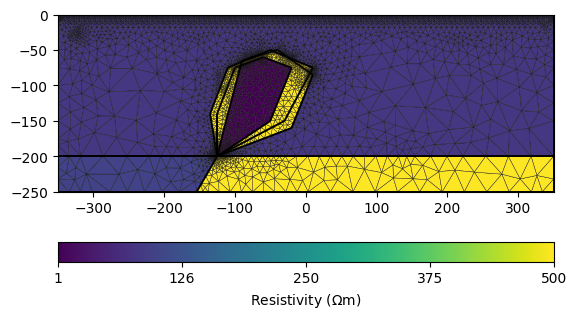

In [93]:
for p in scheme.sensors():
    geom.createNode(p)
    geom.createNode(p - [0, 0.1])

# Create a mesh for the finite element modelling with appropriate mesh quality.
mesh = mt.createMesh(geom, quality=34)

# Define resistivity values for different regions
A = 500.  # Resistivity of siliciclastic rocks (Quartz sandstone, clear, with conglomeratic layers)
B = 80.   # Resistivity of a quaternary aquifer with fresh water
C = 100.   # Resistivity of Limolite and shale
D = 50.    # Resistivity of outer plume
E = 25.    # Resistivity of middle plume
F = 1.     # Resistivity of inner plume

# Create a map to set resistivity values in the appropriate regions
rhomap = [[0, A],
          [1, B],
          [2, C],
          [3, D],
          [4, E],
          [5, F]]

# Take a look at the mesh and the resistivity distribution
pg.show(mesh, data=rhomap, label=pg.unit('res'), showMesh=True)

Perform the modeling with the mesh and the measuring scheme itself
and return a data container with apparent resistivity values,
geometric factors and estimated data errors specified by the noise setting.
The noise is also added to the data. Here 3% plus 1µV.
Note, we force a specific noise seed as we want reproducable results for
testing purposes.



In [94]:
data = ert.simulate(mesh, scheme=scheme, res=rhomap, noiseLevel=1,
                    noiseAbs=1e-6, seed=1337)

pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

27/08/23 - 20:03:25 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 3 within mesh.
27/08/23 - 20:03:25 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 4 within mesh.


ModellingBase::setMesh() copying new mesh ... Found datafile: 96 electrodes
Found: 96 free-electrodes
rMin = 3.68421, rMax = 1400
NGauLeg + NGauLag for inverse Fouriertransformation: 15 + 4
Found non-Neumann domain
0.0859869 s
FOP updating mesh dependencies ... 2.2e-06 s


27/08/23 - 20:03:27 - pyGIMLi - INFO - 0.4750545080807755 3908.4869319652607
27/08/23 - 20:03:27 - pyGIMLi - INFO - Simulated data Data: Sensors: 96 data: 2209, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
27/08/23 - 20:03:27 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
27/08/23 - 20:03:27 - pyGIMLi - INFO - Simulated rhoa (min/max) 71.22400573831834 109.86379522227284
27/08/23 - 20:03:27 - pyGIMLi - INFO - Selected data noise %(min/max) 1.0000578432558072 1.0500508374979798


Calculating response for model: min = 1 max = 500
Allocating memory for primary potential...... 0.008197

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 2.20748s
Response: min = 72.8075 max = 108.237 mean = 82.8035
Reciprocity rms(modelReciprocity) 0.532759%, max: 1.22887%
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.01000057843255807 : 0.010500508374979798


Optional: you can filter all values and tokens in the data container.
Its possible that there are some negative data values due to noise and
huge geometric factors. So we need to remove them.



27/08/23 - 20:03:27 - pyGIMLi - INFO - Filtered rhoa (min/max) 71.22400573831834 109.86379522227284


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f68891ba050>)

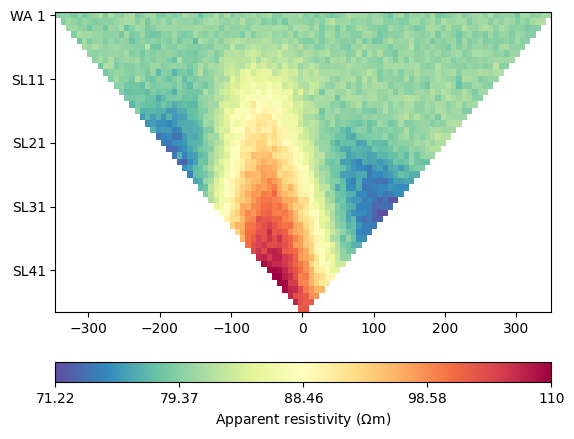

In [95]:
data.remove(data['rhoa'] < 0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

# You can save the data for further use
data.save('Forward_mod.dat')

# You can take a look at the data
ert.show(data)

## Inversion with the ERTManager
Initialize the ERTManager, e.g. with a data container or a filename.



In [96]:
mgr = ert.ERTManager('Forward_mod.dat')

Run the inversion with the preset data. 
Since I set noise level to 1%, chi^2 target should be close to 0.9 or sighly above, also the regularization parameter should be in the range of 10 to 50 (I chose 30).



In [97]:
inv = mgr.invert(lam=30, verbose=True)
np.testing.assert_approx_equal(mgr.inv.chi2(), 0.9, significant=1)

27/08/23 - 20:03:28 - pyGIMLi - INFO - Found 2 regions.
27/08/23 - 20:03:28 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
27/08/23 - 20:03:28 - pyGIMLi - INFO - Found 2 regions.
27/08/23 - 20:03:28 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
27/08/23 - 20:03:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
27/08/23 - 20:03:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
27/08/23 - 20:03:28 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 3861 Cells: 7264 Boundaries: 5676
27/08/23 - 20:03:28 - pyGIMLi - INFO - Use median(data values)=80.4482529561697
27/08/23 - 20:03:28 - pyGIMLi - INFO - Created startmodel from forward operator: 1519 [80.4482529561697,...,80.4482529561697]
27/08/23 - 20:03:28 - pyGIMLi - INFO - Starting inversion.


Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  1

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.

Output milliseconds:  0
Total running milliseconds:  1

Statistics:

  Input vertices: 199
  Input segments: 200
  Input holes: 0

  Mesh vertices: 1023
  Mesh triangles: 1816
  Mesh edges: 2838
  Mesh exterior boundary edges: 228
  Mesh interior boundary edges: 29
  Mesh subsegments (constrained edges): 257

min/max(dweight) = 95.2335/99.9942
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x7f6889469ad0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x7f68898ff470>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x7f68894633d0>
min/max (data): 7

KeyboardInterrupt: 

Let the ERTManger show you the model of the last successful run and how it
fits the data. Shows data, model response, and model.



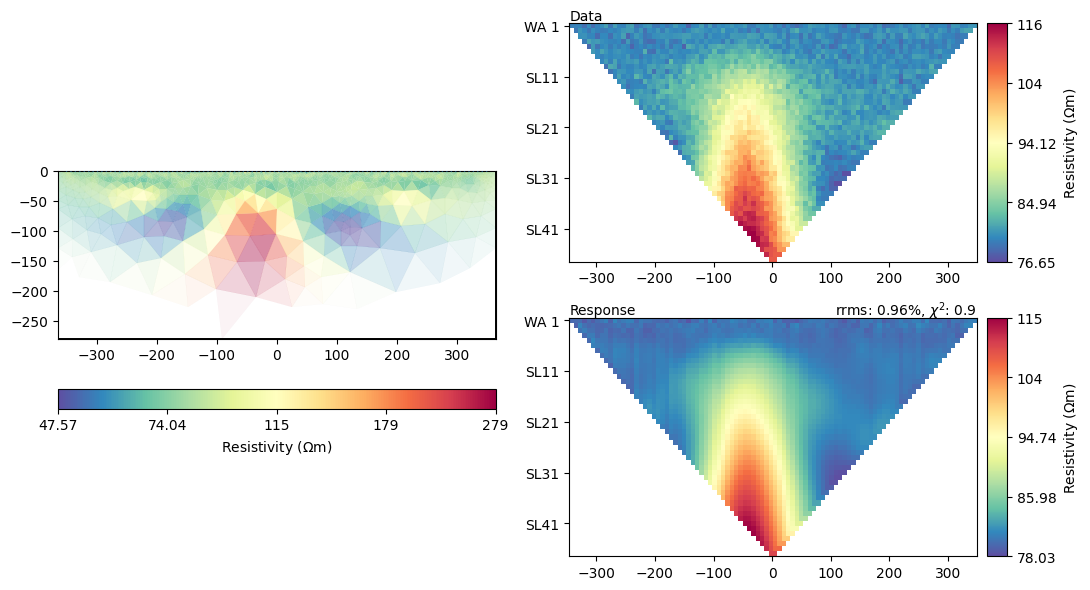

In [ ]:
mgr.showResultAndFit()
meshPD = pg.Mesh(mgr.paraDomain) # Save copy of para mesh for plotting later